In [1]:
import os
import time
import sys
import json
import numpy as np
import ipyvolume as ipv
from pathlib import Path
import pandas as pd
import random
from datetime import datetime

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.generation import ellipsoid_sheet
from tyssue.draw import sheet_view
from tyssue.draw.ipv_draw import view_ipv
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.dynamics import effectors, units
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics.factory import model_factory
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.topology.sheet_topology import remove_face
from tyssue.utils.decorators import do_undo
from tyssue.utils import to_nd
from tyssue.io import hdf5
from tyssue import SheetGeometry as geom

import matplotlib.pyplot as plt

%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')

#from polarity.solver import find_energy_min

In [2]:
import numpy as np
import pandas as pd
from tyssue import config
from scipy import optimize
from scipy.sparse import coo_matrix
from tyssue.utils import data_at_opposite


def find_energy_min(sheet, geom, model, pos_idx=None, **settings_kw):
    #coords = ['x', 'y', 'z']
    # Loads 'tyssue/config/solvers/minimize.json
    settings = config.solvers.minimize_spec()
    settings.update(**settings_kw)

    c0_bazooka = sheet.edge_df['C_a_bazooka']
    c0_myosin  = sheet.edge_df['C_a_myosin']
    c0 = np.concatenate((c0_bazooka.values, c0_myosin.values))
    
    row = sheet.edge_df['face'].append(sheet.edge_df['face']+sheet.Nf).values
    col = sheet.edge_df.index.append(sheet.edge_df.index+sheet.Ne).values
    
    matrix = coo_matrix((sheet.edge_df.length.append(sheet.edge_df.length).values, (row, col)),
                        shape=(sheet.Nf*2, sheet.Ne*2)).toarray()

    # Double linear constrain on bazooka and myosin concentration on a cell
    linear_constraint = optimize.LinearConstraint(
        matrix,
        sheet.face_df['prefered_N_a_bazooka'].append(sheet.face_df['prefered_N_a_bazooka']).reset_index(drop=True),
        sheet.face_df['prefered_N_a_myosin'].append(sheet.face_df['prefered_N_a_myosin']).reset_index(drop=True))

    # Protein quantity on edge always >= 0
    bounds = optimize.Bounds(np.zeros(sheet.Ne*2), np.full((sheet.Ne*2), np.inf))

    res = optimize.minimize(
        chem_energy,
        c0,
        args=(sheet),
        bounds=bounds,
        #constraints=linear_constraint,
        #jac=chem_grad,
        **settings["minimize"]
    )
    

    return res


def set_concentration(sheet, c):
    c_bazooka = np.split(c,2)[0]
    c_myosin  = np.split(c,2)[1]
    sheet.edge_df['C_a_bazooka'] = c_bazooka
    sheet.edge_df['C_a_myosin']  = c_myosin

    sheet.edge_df['N_a_bazooka'] = sheet.edge_df['C_a_bazooka'] * sheet.edge_df['length']
    sheet.edge_df['N_a_myosin']  = sheet.edge_df['C_a_myosin']  * sheet.edge_df['length']


def chem_energy(c, sheet):

    set_concentration(sheet, c)

    # Auto enrichissement
    P1 = (- sheet.settings['q_bazooka'] * sheet.edge_df['C_a_bazooka']**2
          - sheet.settings['q_myosin']  * sheet.edge_df['C_a_myosin'] **2).values

    # Myosin inhibition by bazooka
    P2 = - sheet.settings['k'] * sheet.edge_df['C_a_bazooka'] / sheet.edge_df['C_a_myosin']

    # Constraint on concentration
    P4 = ((sheet.settings['lambda_b'] * 
          (sheet.sum_face(sheet.edge_df['C_a_bazooka'])['C_a_bazooka'] - sheet.face_df['prefered_C_a_bazooka'])**2)
        + (sheet.settings['lambda_m'] * 
          (sheet.sum_face(sheet.edge_df['C_a_myosin'])['C_a_myosin'] - sheet.face_df['prefered_C_a_myosin'])**2))



    return (P1 + P2 + P4).sum()


"""def chem_grad_bazooka(c, sheet):
    # Part1
    P1 = (- sheet.settings['q_bazooka'] * sheet.edge_df['C_a_bazooka']).values

    # Part3
    P2 = - sheet.settings['k'] / sheet.edge_df['C_a_myosin']

    grad = (P1 + P2)

    return grad.values.ravel()

def chem_grad_bazooka(c, sheet):
    # Part1
    P1 = (- sheet.settings['q_myosin'] * sheet.edge_df['C_a_myosin']).values

    # Part3
    P2 = sheet.settings['k'] * sheet.edge_df['C_a_bazooka'] / sheet.edge_df['C_a_myosin'] ** 2

    grad = (P1 + P2)

    return grad.values.ravel()
"""

def _calculate_diff_C_neighbors(sheet):
    C1_ij = sheet.edge_df.sort_values(['face', 'trgt'])['C_a']
    C1_jm = sheet.edge_df.sort_values(['face', 'srce'])['C_a']
    couple1 = pd.DataFrame(
        {'ij': C1_ij.values, 'jm': C1_jm.values}, index=C1_ij.index)
    diff_couple1 = couple1['ij'] - couple1['jm']
    diff_couple1.sort_index(axis='index', inplace=True)

    C2_ij = sheet.edge_df.sort_values(['face', 'srce'])['C_a']
    C2_ni = sheet.edge_df.sort_values(['face', 'trgt'])['C_a']
    couple2 = pd.DataFrame(
        {'ij': C2_ij.values, 'ni': C2_ni.values}, index=C2_ij.index)
    diff_couple2 = couple2['ij'] - couple2['ni']
    diff_couple2.sort_index(axis='index', inplace=True)

    return (diff_couple1, diff_couple2)


In [3]:
class LineTensionPolarity(effectors.AbstractEffector):

    dimensions = units.line_tension
    magnitude = "line_tension_polarity"
    label = "Line tension with polarity"
    element = "edge"
    specs = {"edge": {"is_active", "line_tension", "C_a"}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(
            "line_tension" "* is_active" "* length" "* C_a"
        )  # accounts for half edges

    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("line_tension * is_active/2 * C_a"), len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt

In [4]:
EllipsoidBModel = model_factory(
    [
    effectors.FaceContractility,
    effectors.FaceVolumeElasticity,
    ], effectors.FaceAreaElasticity)

model = EllipsoidBModel


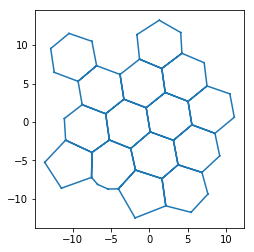

In [5]:
from tyssue.stores import stores_dir
from tyssue.config.geometry import cylindrical_sheet

h5store = os.path.join(stores_dir, "15_cells_patch.hf5")

datasets = hdf5.load_datasets(h5store, data_names=["face", "vert", "edge"])
specs = cylindrical_sheet()
sheet = Sheet("emin", datasets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.vert_df['radial_tension'] = 0.

fig, ax = quick_edge_draw(sheet, coords=list('xy'))
sheet.get_opposite()

In [6]:
# Add column 'C_a' to face_df, which contains the total quantity of protein a in the cell
sheet.face_df['prefered_N_a_bazooka'] = 1

# Add column 'C_a' to edge_df, whoch contains the quantity of protein along one edge
sheet.edge_df['C_a_bazooka'] = 0
sheet.edge_df['N_a_bazooka'] = 1/sheet.upcast_face('num_sides')
sheet.edge_df['N_a_bazooka'] = np.random.uniform(0,0.3, sheet.Ne)

faces_N_a = sheet.sum_face(sheet.edge_df['N_a_bazooka'])
sheet.edge_df['N_a_bazooka'] = (sheet.edge_df['N_a_bazooka'] 
                        * sheet.upcast_face(sheet.face_df['prefered_N_a_bazooka']/faces_N_a['N_a_bazooka']))

sheet.edge_df['C_a_bazooka'] = sheet.edge_df['N_a_bazooka'] / sheet.edge_df.length
    
# Add column 'C_a' to face_df, which contains the total quantity of protein a in the cell
sheet.face_df['prefered_N_a_myosin'] = 1

# Add column 'C_a' to edge_df, whoch contains the quantity of protein along one edge
sheet.edge_df['C_a_myosin'] = 0
sheet.edge_df['N_a_myosin'] = 1/sheet.upcast_face('num_sides')
sheet.edge_df['N_a_myosin'] = np.random.uniform(0,0.3, sheet.Ne)

faces_N_a = sheet.sum_face(sheet.edge_df['N_a_myosin'])
sheet.edge_df['N_a_myosin'] = (sheet.edge_df['N_a_myosin'] 
                        * sheet.upcast_face(sheet.face_df['prefered_N_a_myosin']/faces_N_a['N_a_myosin']))

sheet.edge_df['C_a_myosin'] = sheet.edge_df['N_a_myosin'] / sheet.edge_df.length
  
    
sheet.settings ['q_myosin'] = 0.2
sheet.settings ['q_bazooka'] = 0.2
sheet.settings ['k'] = 0.4
sheet.settings ['lambda_b'] = 1
sheet.settings ['lambda_m'] = 1

Text(0.5,1,'myosin')

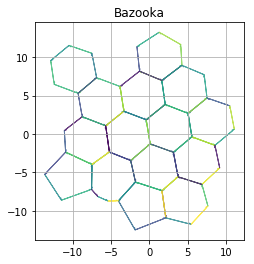

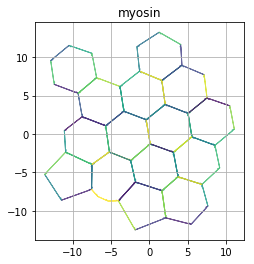

In [7]:
# Forme du tissu au debut
sheet2 = sheet.extract_bounding_box(y_boundary=[-100,100], x_boundary = [-200,200], z_boundary=[-400,400])
fig, ax = sheet_view(sheet2, edge={'color_range': [0,0.1],'color':sheet2.edge_df.C_a_bazooka, 'width':1}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('Bazooka')

sheet2 = sheet.extract_bounding_box(y_boundary=[-100,100], x_boundary = [-200,200], z_boundary=[-400,400])
fig, ax = sheet_view(sheet2, edge={'color_range': [0,0.1],'color':sheet2.edge_df.C_a_myosin, 'width':1}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('myosin')


In [8]:
import time 
time_init=time.time()
solver_kw = {'minimize': {'method': 'SLSQP',
                          'options': {'ftol': 1e-2,
                                      'maxiter': 20}}}
                                      #'gtol': 1e-8}}}
res = find_energy_min(sheet, geom, model, **solver_kw)
print(res)
time_end = time.time()-time_init
#print (tmps2)


/home/admin-suz/anaconda3/lib/python3.6/site-packages/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon


     fun: 0.0
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 567
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, n

/home/admin-suz/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


Text(0.5,1,'myosin')

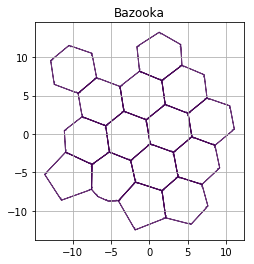

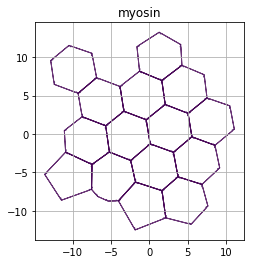

In [9]:
# Forme du tissu au debut
sheet2 = sheet.extract_bounding_box(y_boundary=[-100,100], x_boundary = [-200,200], z_boundary=[-400,400])
fig, ax = sheet_view(sheet2, edge={'color_range': [0,0.1],'color':sheet2.edge_df.C_a_bazooka, 'width':1}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('Bazooka')

sheet2 = sheet.extract_bounding_box(y_boundary=[-100,100], x_boundary = [-200,200], z_boundary=[-400,400])
fig, ax = sheet_view(sheet2, edge={'color_range': [0,0.1],'color':sheet2.edge_df.C_a_myosin, 'width':1}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('myosin')


/home/admin-suz/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/admin-suz/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

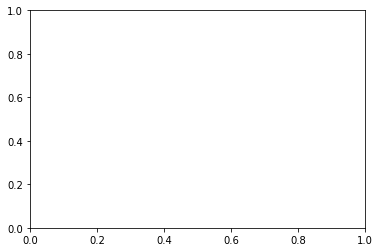

In [10]:
H = plt.hist (sheet.edge_df.C_a_bazooka*sheet.edge_df.length)
H = plt.hist (sheet.edge_df.C_a_myosin*sheet.edge_df.length)